In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import itertools
import math

# ============================================================
# 1. PFN with CAUSAL attention, NO pos enc
# ============================================================

class BernoulliPFN(nn.Module):
    def __init__(self, d_model=64, nhead=4, num_layers=4):
        super().__init__()
        self.embedding = nn.Embedding(2, d_model) #hard-coded for vocab size=2
        enc = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc, num_layers)
        self.unembed = nn.Linear(d_model, 1)

    def forward(self, ctx, z_soft=None):
        """
        ctx: (B,T) tokens in {0,1}
        z_soft: (1,m,d) soft prefix (optional)

        Returns:
            logits: (B, S, 1) where S = T (if z_soft is None) or S = m + T (if z_soft is present)
        """
        h = self.embedding(ctx)  # (B,T,d)

        if z_soft is not None:
            z = z_soft.expand(h.size(0), -1, -1)  # (B,m,d)
            h = torch.cat([z, h], dim=1)

        # S is the total sequence length:
        # S = T       if z_soft is None
        # S = m + T   if z_soft is not None
        S = h.size(1)

        causal_mask = torch.triu(
            torch.ones(S, S, device=h.device),
            diagonal=1
        ).bool()

        out = self.transformer(h, mask=causal_mask)

        # Return logits for ALL positions.
        # Output shape is (B, S, 1).
        # If z_soft was used, the first m outputs correspond to the prefix positions
        # and the last T outputs correspond to the token positions.
        return self.unembed(out)


# ============================================================
# 2. Meta-training (Beta–Bernoulli)
# ============================================================

def meta_train(model, cfg, device):
    opt = optim.Adam(model.parameters(), lr=5e-4)
    loss_fn = nn.BCEWithLogitsLoss()
    model.to(device)
    model.train()

    print("[meta] training PFN...")
    for i in range(cfg["train_iter"]):
        p = torch.rand(cfg["train_batch"], 1, device=device) # prior unif(0,1)
        seq = (torch.rand(cfg["train_batch"], cfg["train_seq_len"], device=device) < p).long()

        # T = cfg["train_seq_len"]
        # Input: x_1 ... x_{T-1}
        # Target: x_2 ... x_T
        inp = seq[:, :-1]
        target = seq[:, 1:].float()

        all_logits = model(inp)  # (B, T-1, 1)

        # If z_soft was None, output shape matches input shape.
        loss = loss_fn(all_logits.reshape(-1), target.reshape(-1))

        opt.zero_grad()
        loss.backward()
        opt.step()

        if i % cfg["meta_log_every"] == 0:
            print(f"[meta] step {i:5d} | loss {loss.item():.6f}")

    model.eval()


# ============================================================
# 3. Predictive Monte Carlo samples
# ============================================================

from tqdm.auto import tqdm

@torch.no_grad()
def pmc(model, ctx, L, rollout_len):
    device = ctx.device
    ctx = ctx.view(1, -1).long()
    samples = torch.empty(L, device=device)

    for l in tqdm(range(L), desc="PMC samples", leave=True):
        hist = ctx.clone()
        for _ in range(rollout_len):
            # We only need the prediction for the LAST token added
            out = model(hist)
            p1 = torch.sigmoid(out[:, -1, :]).view(())      # scalar
            next = torch.bernoulli(p1).long().view(1, 1)  # (1,1)
            hist = torch.cat([hist, next], dim=1)

        # Final prediction
        out = model(hist)
        samples[l] = torch.sigmoid(out[:, -1, :]).view(())

    return samples




# ============================================================
# 4. μ(p)
# ============================================================

def mu(p, tau, N):
    tau = torch.tensor(tau, device=p.device, dtype=p.dtype)
    return N * (-torch.log(1 - tau) + p * torch.log((1 - tau) / tau))


def exact_grad_norm_J(model, ctx, z, cfg):
    """
    Returns (J_exact(z) as float, ||∇_z J_exact(z)||_2 as float).
    This does NOT update model params; it only differentiates w.r.t. z.
    """
    z_ = z.clone().detach().requires_grad_(True)
    J = J_exact(model, ctx, z_, cfg)  # your differentiable objective
    (g,) = torch.autograd.grad(J, z_, retain_graph=False, create_graph=False)
    return float(J.item()), float(g.norm().item())



# ============================================================
# 5. Elicitation gradient (predictive MC)
# ============================================================
@torch.no_grad()
def elicitation_grad(model, z, pmc_samples, cfg, eps=1.0):
    """
    Predictive-MC elicitation gradient estimator + IS diagnostics.

    Returns:
      grad: (1,m,d) tensor
      diag: dict with ESS / max weight / etc.
    """
    device = z.device
    L = int(pmc_samples.shape[0])
    m, d = int(z.shape[1]), int(z.shape[2])

    phi0 = model.embedding(torch.tensor([0], device=device)).detach().view(1, 1, d)
    phi1 = model.embedding(torch.tensor([1], device=device)).detach().view(1, 1, d)

    def kappa(zj, phi):
        return torch.exp(-0.5 * ((zj - phi) ** 2).sum(dim=-1) / (eps**2))

    k0 = kappa(z, phi0)  # (1,m)
    k1 = kappa(z, phi1)  # (1,m)

    p = pmc_samples.view(L, 1).clamp(1e-6, 1 - 1e-6)  # (L,1)

    # log-space mixture q = p*k1 + (1-p)*k0 for stability
    logk0 = torch.log(k0 + 1e-30)  # (1,m)
    logk1 = torch.log(k1 + 1e-30)  # (1,m)

    loga = torch.log(p)       + logk1         # (L,m)
    logb = torch.log1p(-p)    + logk0         # (L,m)
    logq = torch.logaddexp(loga, logb)        # (L,m)

    logw = logq.sum(dim=1)                    # (L,)
    w = torch.softmax(logw, dim=0)            # normalized weights (L,)

    # ESS diagnostics
    ess = 1.0 / (w.square().sum() + 1e-12)
    max_w = w.max()
    diag = {
        "ess": float(ess.item()),
        "ess_frac": float((ess / L).item()),
        "max_w": float(max_w.item()),
    }

    # responsibilities
    omega1 = torch.exp(loga - logq)           # (L,m)
    omega0 = torch.exp(logb - logq)           # (L,m)

    mu_vals = mu(pmc_samples, cfg["target_tau"], cfg["eval_horizon_N"])  # (L,)
    mu_bar = (w * mu_vals).sum()                                     # scalar

    zL = z.expand(L, -1, -1)  # (L,m,d)
    score = -(omega1.unsqueeze(-1) * (zL - phi1) +
              omega0.unsqueeze(-1) * (zL - phi0)) / (eps**2)         # (L,m,d)

    score_bar = (w.view(L, 1, 1) * score).sum(dim=0, keepdim=True)    # (1,m,d)

    grad = (w.view(L, 1, 1) *
            (mu_vals.view(L, 1, 1) - mu_bar) *
            (score - score_bar)).sum(dim=0, keepdim=True)             # (1,m,d)

    return grad, diag

# ============================================================
# 6. Exact objective J_exact (2^N enumeration)
# ============================================================

def J_exact(model, ctx, z, cfg):
    device = ctx.device
    N = cfg["eval_horizon_N"]
    tau = cfg["target_tau"]

    total = torch.zeros((), device=device)
    for seq in itertools.product([0, 1], repeat=N):
        prob = torch.ones((), device=device)
        hist = ctx.view(1, -1)

        for bit in seq:
            # Forward pass: hist -> (B, T, 1)
            # We want the LAST prediction
            p1 = torch.sigmoid(model(hist, z)[:, -1, :]).view(())
            prob = prob * (p1 if bit == 1 else (1 - p1))

            hist = torch.cat([hist, torch.tensor([[bit]], device=device)], dim=1)

        s = sum(seq)
        util = -s * math.log(tau) - (N - s) * math.log(1 - tau)
        total = total + prob * util


    return total


def sample_eval_ctx(cfg, device):
    """
    Samples ctx ~ Bernoulli(p_ctx)^{eval_ctx_len} and prints realized ones fraction.
    """
    p_ctx = float(cfg["eval_ctx_p"])
    n = int(cfg["eval_ctx_len"])

    probs = torch.full((n,), p_ctx, device=device)
    ctx = torch.bernoulli(probs).to(torch.long)

    ones = int(ctx.sum().item())
    frac = float(ctx.float().mean().item()) if n > 0 else float("nan")
    print(f"[ctx] Bernoulli(p_ctx={p_ctx:.3f}) | n={n} | ones={ones} | frac_ones={frac:.3f}")

    return ctx


# ============================================================
# 7. Intuitive success metric: expected next-token probability
# ============================================================

@torch.no_grad()
def exact_eval(model, ctx, z, cfg):
    """
    Exact evaluation under the model-induced continuation distribution over horizon N.

    Returns a dict:
      - J     : float, J_exact(z) = E[-log xi_tau*(Y_{n+1:n+N})]
      - p_marg: list[float] length N, where p_marg[t-1] = P(Y_{n+t}=1 | ctx,z)
      - p1    : float, p_marg[0]
      - pbarN : float, mean(p_marg)
    """
    device = ctx.device
    N = int(cfg["eval_horizon_N"])
    tau = float(cfg["target_tau"])

    log_tau = math.log(tau)
    log1m   = math.log(1.0 - tau)

    # p_marg[t] = P(Y_{n+(t+1)}=1)
    p_marg = torch.zeros(N, device=device)
    J = torch.zeros((), device=device)

    zero = torch.zeros((1, 1), device=device, dtype=torch.long)
    one  = torch.ones((1, 1), device=device, dtype=torch.long)

    def rec(hist, t, prob_prefix, s_ones):
        nonlocal J

        # p = P(next=1 | hist,z)
        p = torch.sigmoid(model(hist, z)[:, -1, :]).view(())  # scalar in (0,1)
        p_marg[t] += prob_prefix * p

        if t == N - 1:
            # expectation over the last bit without further recursion
            util0 = -(s_ones)     * log_tau - (N - s_ones)     * log1m
            util1 = -(s_ones + 1) * log_tau - (N - (s_ones+1)) * log1m
            J += prob_prefix * ((1 - p) * util0 + p * util1)
            return

        rec(torch.cat([hist, zero], dim=1), t + 1, prob_prefix * (1 - p), s_ones)
        rec(torch.cat([hist, one],  dim=1), t + 1, prob_prefix * p,       s_ones + 1)

    rec(ctx.view(1, -1), 0, torch.ones((), device=device), 0)

    p_marg_list = [float(x.item()) for x in p_marg]
    p1 = p_marg_list[0]
    pbarN = float(sum(p_marg_list) / N)

    return {"J": float(J.item()), "p_marg": p_marg_list, "p1": p1, "pbarN": pbarN}


@torch.no_grad()
def expected_p1(model, ctx, z):
    # Take the last logit
    return torch.sigmoid(model(ctx.view(1, -1), z)[:, -1, :]).item()

@torch.no_grad()
def exact_metrics(model, ctx, z, cfg):
    """
    Computes exact metrics by enumerating all 2^N possible binary continuations.

    Returns:
        J (float): Exact expected utility (KL divergence based reward).
        pbar (float): Expected proportion of 1s in the continuation.
    """
    device = ctx.device
    N = cfg["eval_horizon_N"]
    tau = cfg["target_tau"]

    J = torch.zeros((), device=device)
    pbar = torch.zeros((), device=device)

    for seq in itertools.product([0, 1], repeat=N):
        prob = torch.ones((), device=device)
        hist = ctx.view(1, -1)

        for bit in seq:
            p1 = torch.sigmoid(model(hist, z)[:, -1, :]).view(())  # scalar
            prob = prob * (p1 if bit == 1 else (1 - p1))
            hist = torch.cat([hist, torch.tensor([[bit]], device=device)], dim=1)

        s = sum(seq)
        J = J + prob * (-s * math.log(tau) - (N - s) * math.log(1 - tau))
        pbar = pbar + prob * (s / N)

    return J.item(), pbar.item()

import time

def _sync():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

import time
from tqdm.auto import tqdm
import torch

def optimize_exact_z(model, ctx, z_init, cfg):
    steps = int(cfg.get("opt_steps_exact", 0))
    log_every = int(cfg.get("log_every_exact", 50))

    z_ex = z_init.clone().detach().requires_grad_(True)
    logs = {}

    _sync(); t0 = time.perf_counter()

    if steps == 0:
        _sync(); t1 = time.perf_counter()
        return z_ex.detach(), logs, (t1 - t0)

    pbar = tqdm(range(steps), desc="Direct Opt (z_ex)", leave=True)
    for step in pbar:
        J = J_exact(model, ctx, z_ex, cfg)  # autograd wrt z_ex

        if step % log_every == 0:
            _sync()
            elapsed = time.perf_counter() - t0

            m = exact_eval(model, ctx, z_ex.detach(), cfg)  # unified J/p1/pbarN/p_marg
            m["step"] = int(step)
            m["t"] = float(elapsed)  # seconds since start of this optimizer
            logs[step] = m

            pbar.set_postfix(
                t=f"{elapsed:7.2f}s",
                J=f"{m['J']:.4f}",
                p1=f"{m['p1']:.3f}",
                pbarN=f"{m['pbarN']:.3f}",
            )

        J.backward()
        with torch.no_grad():
            z_ex -= float(cfg["lr"]) * z_ex.grad
            z_ex.grad.zero_()

    _sync(); t1 = time.perf_counter()
    return z_ex.detach(), logs, (t1 - t0)




import time
from tqdm.auto import tqdm
import torch

def optimize_elicitation_z(model, ctx, z_init, pmc_samples, cfg):
    steps = int(cfg.get("opt_steps_elic", 1000))
    log_every = int(cfg.get("log_every_elic", 100))
    eps = float(cfg.get("eps", 1.0))

    z_el = z_init.clone().detach()
    logs = {}

    _sync(); t0 = time.perf_counter()

    pbar = tqdm(range(steps), desc="Elicitation Opt (z_el)", leave=True)
    for step in pbar:
        # proxy gradient + IS diagnostics at current z
        g_el, diag = elicitation_grad(model, z_el, pmc_samples, cfg, eps=eps)

        if step % log_every == 0:
            _sync()
            elapsed = time.perf_counter() - t0

            # exact eval for reporting
            m = exact_eval(model, ctx, z_el, cfg)
            # exact gradient norm diagnostic (are we *actually* stuck for J_exact?)
            _, gJ_norm = exact_grad_norm_J(model, ctx, z_el, cfg)

            m.update(diag)
            m["g_el_norm"] = float(g_el.norm().item())
            m["gJ_exact_norm"] = float(gJ_norm)
            m["step"] = int(step)
            m["t"] = float(elapsed)  # seconds since start of this optimizer

            logs[step] = m

            pbar.set_postfix(
                t=f"{elapsed:7.2f}s",
                J=f"{m['J']:.4f}",
                pbarN=f"{m['pbarN']:.3f}",
                gJ=f"{m['gJ_exact_norm']:.2e}",
                ESS=f"{m['ess']:.1f}",
                maxw=f"{m['max_w']:.2e}",
            )

        with torch.no_grad():
            z_el -= float(cfg["lr"]) * g_el

    _sync(); t1 = time.perf_counter()
    return z_el, logs, (t1 - t0)



In [ ]:
# ------------------------
# Run experiment
# ------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = dict(
    train_iter=5000,
    meta_log_every=500,
    train_seq_len=200,
    train_batch=32,

    eval_ctx_p = 0.3,
    eval_ctx_len=10,
    eval_horizon_N=4,
    target_tau=0.2,

    pcm_num_samples=500,
    rollout_len=190,

    d_model=64,
    m_prompts=6,

    # phase-specific
    opt_steps_exact=1000,        # set 0 to skip phase 1 entirely
    log_every_exact=50,

    opt_steps_elic=50000,      # run phase 2 long
    log_every_elic=1000,

    lr=0.05,
    eps=4.0,
)



print("\n=== CONFIG ===")
for k, v in cfg.items():
    print(f"{k:>20}: {v}")
print("==============\n")


=== CONFIG ===
          train_iter: 5000
      meta_log_every: 500
       train_seq_len: 200
         train_batch: 32
          eval_ctx_p: 0.3
        eval_ctx_len: 10
      eval_horizon_N: 4
          target_tau: 0.2
     pcm_num_samples: 500
         rollout_len: 190
             d_model: 64
           m_prompts: 6
     opt_steps_exact: 1000
     log_every_exact: 50
      opt_steps_elic: 50000
      log_every_elic: 1000
                  lr: 0.05
                 eps: 4.0



In [ ]:

model = BernoulliPFN(cfg["d_model"]).to(device)
meta_train(model, cfg, device)


[meta] training PFN...
[meta] step     0 | loss 0.738332
[meta] step   500 | loss 0.527415
[meta] step  1000 | loss 0.555844
[meta] step  1500 | loss 0.506569
[meta] step  2000 | loss 0.507039
[meta] step  2500 | loss 0.480662
[meta] step  3000 | loss 0.535317
[meta] step  3500 | loss 0.522678
[meta] step  4000 | loss 0.517309
[meta] step  4500 | loss 0.524670


In [ ]:
# ------------------------
# Fixed evaluation context
# ------------------------
ctx = sample_eval_ctx(cfg, device)


# Shared init for both paths
z0 = torch.randn(1, cfg["m_prompts"], cfg["d_model"], device=device)

# ------------------------
# Direct Optimization (Exact Gradient) (OPTIONAL)
# ------------------------
steps_exact = int(cfg.get("opt_steps_exact", 0))
if steps_exact > 0:
    print(f"\n[Direct Opt] optimize z_ex by exact ∇J_exact for {steps_exact} steps ...")
    z_ex_ref, logs_ex, t_exact = optimize_exact_z(model, ctx, z0, cfg)
    print(f"[time] exact optimization: {t_exact:.3f}s")
else:
    print("\n[Direct Opt] skipping exact optimization (using z0 as z_ex reference)")
    z_ex_ref = z0.detach()
    logs_ex = {}
    t_exact = 0.0

# Unified reference metrics (p1 and pbarN from the same exact computation)
ref = exact_eval(model, ctx, z_ex_ref, cfg)
J_ref, p1_ref, pbar_ref = ref["J"], ref["p1"], ref["pbarN"]



[ctx] Bernoulli(p_ctx=0.300) | n=10 | ones=3 | frac_ones=0.300

[Direct Opt] optimize z_ex by exact ∇J_exact for 1000 steps ...


Direct Opt (z_ex):   0%|          | 0/1000 [00:00<?, ?it/s]

[time] exact optimization: 507.039s


In [ ]:
# ------------------------
# Elicitation Optimization (PMC-based)
# ------------------------
print("\n[Elicitation Opt] PMC Sampling ...")
_sync(); t0 = time.perf_counter()
pmc_samples = pmc(model, ctx, cfg["pcm_num_samples"], cfg["rollout_len"])
_sync(); t1 = time.perf_counter()
t_pmc = t1 - t0
print(f"[time] PMC sampling: {t_pmc:.3f}s")

steps_elic = int(cfg.get("opt_steps_elic", 1000))
print(f"\n[Elicitation Opt] optimize z_el by elicitation update for {steps_elic} steps ...")
z_el_final, logs_el, t_elic = optimize_elicitation_z(model, ctx, z0, pmc_samples, cfg)
print(f"[time] elicitation optimization: {t_elic:.3f}s")
print(f"[time] PMC + elicitation total: {t_pmc + t_elic:.3f}s")

# ------------------------
# Comparison table
#   - left columns are the FIXED reference z_ex_ref (Direct Opt)
#   - right columns are the evolving z_el along elicitation steps
# ------------------------
print("\nstep   | J_ex(z_ex)   | J_ex(z_el)   | p1(z_ex) | p1(z_el) | pbarN(z_ex) | pbarN(z_el) | ESS   | ||∇J||")
print("---------------------------------------------------------------------------------------------------------------")
tau = cfg["target_tau"]

for step in sorted(logs_el.keys()):
    m = logs_el[step]
    print(f"{step:6d} | {J_ref:11.4f} | {m['J']:11.4f} | "
          f"{p1_ref:7.3f} | {m['p1']:7.3f} | {pbar_ref:10.3f} | {m['pbarN']:10.3f} | "
          f"{m['ess']:5.1f} | {m['gJ_exact_norm']:.2e}")



[Elicitation Opt] PMC Sampling ...


PMC samples:   0%|          | 0/500 [00:00<?, ?it/s]

[time] PMC sampling: 189.811s

[Elicitation Opt] optimize z_el by elicitation update for 50000 steps ...


Elicitation Opt (z_el):   0%|          | 0/50000 [00:00<?, ?it/s]

[time] elicitation optimization: 81.826s
[time] PMC + elicitation total: 271.636s

step   | J_ex(z_ex)   | J_ex(z_el)   | p1(z_ex) | p1(z_el) | pbarN(z_ex) | pbarN(z_el) | ESS   | ||∇J||
---------------------------------------------------------------------------------------------------------------
     0 |      2.5767 |      2.9928 |   0.304 |   0.380 |      0.304 |      0.379 | 468.1 | 1.90e-01
  1000 |      2.5767 |      2.6680 |   0.304 |   0.320 |      0.304 |      0.320 | 441.8 | 9.54e-02
  2000 |      2.5767 |      2.4356 |   0.304 |   0.278 |      0.304 |      0.278 | 341.4 | 7.57e-02
  3000 |      2.5767 |      2.3728 |   0.304 |   0.267 |      0.304 |      0.267 | 300.4 | 6.59e-02
  4000 |      2.5767 |      2.3433 |   0.304 |   0.261 |      0.304 |      0.262 | 282.2 | 5.26e-02
  5000 |      2.5767 |      2.3251 |   0.304 |   0.258 |      0.304 |      0.258 | 272.0 | 4.68e-02
  6000 |      2.5767 |      2.3121 |   0.304 |   0.256 |      0.304 |      0.256 | 265.6 | 4.36e-02
 

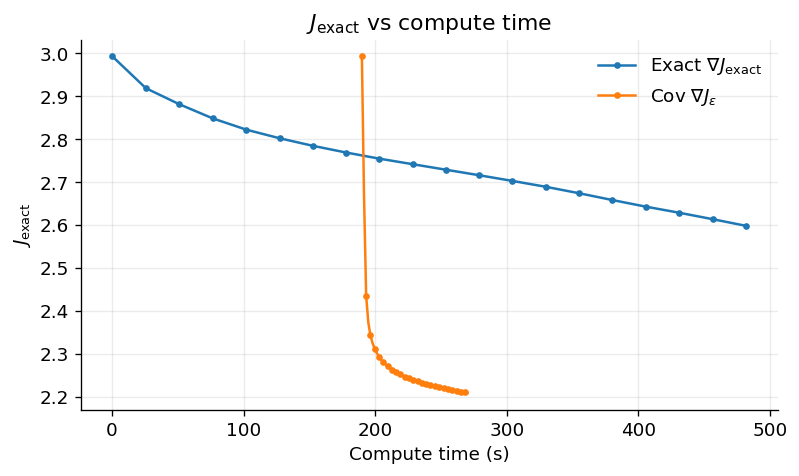

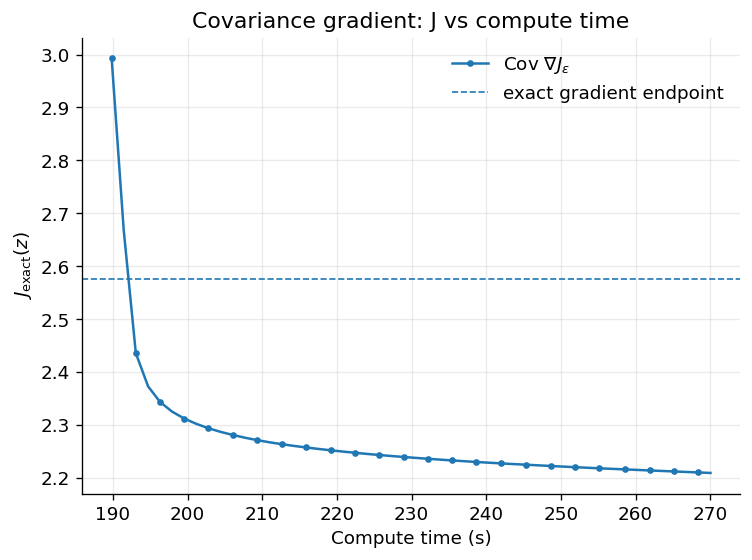

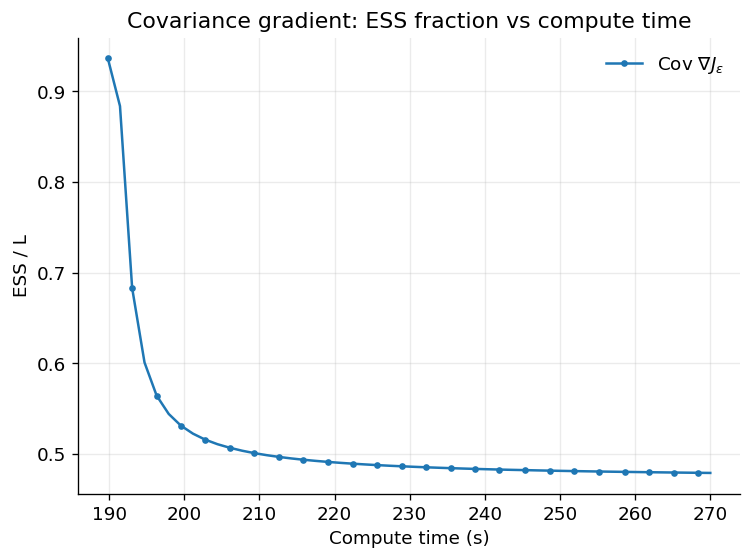

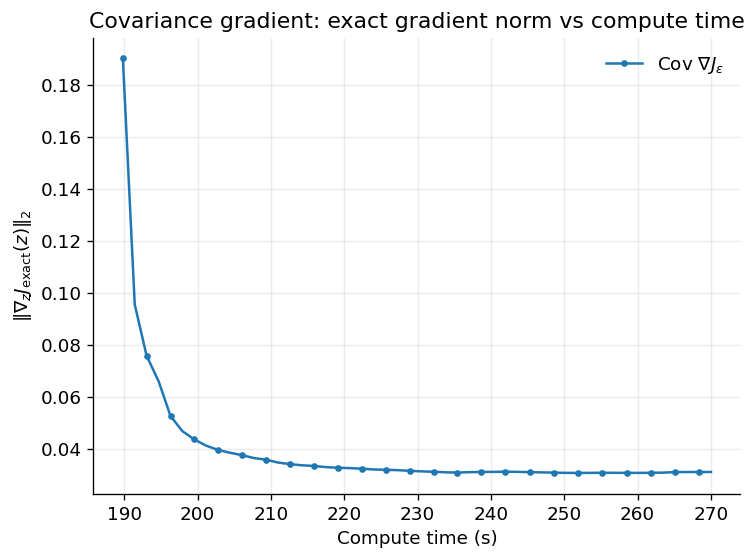

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

def logs_to_df(logs: dict, method: str, t_offset: float = 0.0) -> pd.DataFrame:
    """
    logs: dict[step] -> metrics dict
      expected keys inside metrics:
        - 'J', 'pbarN', 'p1'
        - time key: one of {'t', 't_sec', 't_total'}
      optional:
        - 'ess_frac', 'gJ_exact_norm', 'g_el_norm', 'max_w', 'ess'

    Produces a df with:
      method, step, t_raw, t (t_raw + t_offset), J, pbarN, p1, ...
    """
    rows = []
    for step in sorted(logs.keys()):
        m = logs[step]

        # robust time key handling
        if "t" in m:
            t_raw = float(m["t"])
        elif "t_sec" in m:
            t_raw = float(m["t_sec"])
        elif "t_total" in m:
            t_raw = float(m["t_total"])
        else:
            raise KeyError(
                "logs_to_df: metrics dict must contain a time key in {'t','t_sec','t_total'}; "
                f"got keys={list(m.keys())[:10]}..."
            )

        rows.append({
            "method": str(method),
            "step": int(m.get("step", step)),
            "t_raw": t_raw,
            "t": t_raw + float(t_offset),   # total compute time for plotting
            "J": float(m["J"]),
            "pbarN": float(m["pbarN"]),
            "p1": float(m["p1"]),

            # optional diagnostics
            "ess_frac": float(m.get("ess_frac", np.nan)),
            "ess": float(m.get("ess", np.nan)),
            "max_w": float(m.get("max_w", np.nan)),
            "gJ_exact_norm": float(m.get("gJ_exact_norm", np.nan)),
            "g_el_norm": float(m.get("g_el_norm", np.nan)),
        })

    df = pd.DataFrame(rows)
    if not df.empty:
        df = df.sort_values("t").reset_index(drop=True)
    return df




def add_reference_columns(df: pd.DataFrame, ref: dict, tau: float) -> pd.DataFrame:
    """
    ref: dict from exact_eval(model, ctx, z_ref, cfg)
    Adds baseline columns and deltas for nicer paper presentation.
    """
    J_ref, p1_ref, pbar_ref = float(ref["J"]), float(ref["p1"]), float(ref["pbarN"])

    out = df.copy()
    out["tau"] = float(tau)

    out["J_ref"] = J_ref
    out["pbar_ref"] = pbar_ref
    out["p1_ref"] = p1_ref

    out["dJ"] = out["J"] - J_ref
    out["dpbar"] = out["pbarN"] - pbar_ref
    out["dp1"] = out["p1"] - p1_ref

    # distance-to-target (often what you want in a paper figure)
    out["abs_pbar_minus_tau"] = (out["pbarN"] - tau).abs()
    out["abs_p1_minus_tau"]   = (out["p1"] - tau).abs()
    return out


def select_checkpoints(steps, k=8):
    """
    Pick up to k checkpoint steps including first/last, evenly spaced.
    """
    steps = sorted(set(int(s) for s in steps))
    if len(steps) <= k:
        return steps
    idx = np.linspace(0, len(steps) - 1, k).round().astype(int)
    return [steps[i] for i in idx]


def df_to_latex_table(df: pd.DataFrame, steps=None, caption=None, label=None) -> str:
    """
    Robust LaTeX (booktabs) table generator that does NOT depend on pandas.to_latex().
    Returns a string you can paste into your paper.

    df: output of add_reference_columns(...) for one method
    steps: list of step indices to include (default: evenly spaced checkpoints)
    caption/label: optional LaTeX caption/label (if provided, wraps in table env)
    """
    if steps is None:
        steps = select_checkpoints(df["step"].tolist(), k=8)

    view = df[df["step"].isin(steps)].copy().sort_values("step")

    # Core columns
    cols = ["step", "J", "dJ", "p1", "pbarN", "tau"]

    # Optional diagnostics (include if present)
    for c in ["ess_frac", "gJ_exact_norm", "g_el_norm"]:
        if c in view.columns:
            cols.append(c)

    view = view[cols]

    # Column headers (LaTeX)
    head = {
        "step": "step",
        "J": r"$J_{\mathrm{exact}}$",
        "dJ": r"$\Delta J$",
        "p1": r"$p_1$",
        "pbarN": r"$\bar p_N$",
        "tau": r"$\tau_*$",
        "ess_frac": r"ESS$/L$",
        "gJ_exact_norm": r"$\|\nabla_z J\|_2$",
        "g_el_norm": r"$\|\hat g_\epsilon\|_2$",
    }

    # Formatting by column
    def fmt(col, val):
        if val is None or (isinstance(val, float) and (math.isnan(val) or math.isinf(val))):
            return ""
        if col == "step":
            return f"{int(val)}"
        if col in ("p1", "pbarN", "tau", "ess_frac"):
            return f"{float(val):.3f}"
        if col in ("J", "dJ"):
            return f"{float(val):.4f}"
        if col in ("gJ_exact_norm", "g_el_norm"):
            return f"{float(val):.2e}"
        return f"{val}"

    # Build LaTeX
    col_format = "r" * len(cols)  # all right-aligned numeric
    lines = []

    if caption is not None or label is not None:
        lines.append(r"\begin{table}[t]")
        lines.append(r"\centering")

    lines.append(rf"\begin{{tabular}}{{{col_format}}}")
    lines.append(r"\toprule")
    lines.append(" & ".join(head[c] for c in cols) + r" \\")
    lines.append(r"\midrule")

    for _, row in view.iterrows():
        lines.append(" & ".join(fmt(c, row[c]) for c in cols) + r" \\")

    lines.append(r"\bottomrule")
    lines.append(r"\end{tabular}")

    if caption is not None:
        lines.append(rf"\caption{{{caption}}}")
    if label is not None:
        lines.append(rf"\label{{{label}}}")

    if caption is not None or label is not None:
        lines.append(r"\end{table}")

    return "\n".join(lines)


def _apply_paper_matplotlib_defaults():
    # Keep it minimal and compatible; no explicit color styling
    plt.rcParams.update({
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "legend.frameon": False,
        "font.size": 11,
    })


import matplotlib.pyplot as plt

def plot_curve(df: pd.DataFrame,
               y: str,
               ylabel: str,
               title: str,
               out_pdf: str,
               *,
               x: str = "t",
               xlabel: str | None = None,
               y_ref: float | None = None,
               hline: float | None = None):
    """
    Single clean plot. Saves as PDF for paper.
    Default x-axis is compute time (seconds): x='t'.
    """
    _apply_paper_matplotlib_defaults()

    if df.empty:
        raise ValueError("plot_curve: df is empty")

    if x not in df.columns:
        raise KeyError(f"plot_curve: x='{x}' not in df columns: {list(df.columns)}")

    d = df.sort_values(x)
    xv = d[x].to_numpy()
    yv = d[y].to_numpy()

    # markers only occasionally if many points
    markevery = max(1, len(xv) // 25) if len(xv) > 40 else 1

    plt.figure()
    plt.plot(xv, yv, linewidth=1.5, marker="o", markersize=3, markevery=markevery,
             label=d["method"].iloc[0] if "method" in d.columns else None)

    if y_ref is not None:
        plt.axhline(float(y_ref), linestyle="--", linewidth=1.0, label="exact gradient endpoint")
    if hline is not None:
        plt.axhline(float(hline), linestyle=":", linewidth=1.0, label="target")

    if xlabel is None:
        xlabel = "Compute time (s)" if x == "t" else "Optimization step"

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if (("method" in d.columns) and (d["method"].nunique() == 1)) or (y_ref is not None) or (hline is not None):
        plt.legend()
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()



@torch.no_grad()
def plot_marginal_profile(model, ctx, z, cfg, title: str, out_pdf: str):
    """
    Plots t -> p_t(z) = P(Y_{n+t}=1 | ctx,z), t=1..N
    Uses exact_eval's p_marg (so it's exact over the 2^N tree).
    """
    _apply_paper_matplotlib_defaults()
    m = exact_eval(model, ctx, z, cfg)
    p_marg = np.array(m["p_marg"], dtype=float)
    N = len(p_marg)
    tau = float(cfg["target_tau"])

    plt.figure()
    plt.plot(np.arange(1, N+1), p_marg, marker="o")
    plt.axhline(tau, linestyle=":", linewidth=1.0, label=r"$\tau_*$")
    plt.xlabel(r"horizon index $t$")
    plt.ylabel(r"$p_t(z)=\Pr(Y_{n+t}=1\mid ctx,z)$")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_pdf, bbox_inches="tight")
    plt.show()

    # also return values for convenience
    return m

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_anytime_J(df_exact: pd.DataFrame,
                   df_cov: pd.DataFrame,
                   *,
                   title: str | None = None,
                   savepath: str | None = None,
                   best_so_far: bool = True):
    """
    Paper plot: compute time on x-axis, J_exact on y-axis.
    Compares:
      - Exact ∇J_exact (direct)
      - Covariance ∇J_ε (eval on J_exact), typically with PMC time offset already included in df_cov['t'].
    """
    _apply_paper_matplotlib_defaults()

    plt.figure(figsize=(6.8, 4.1))

    def _plot(df: pd.DataFrame):
        if df.empty:
            return
        d = df.sort_values("t")
        x = d["t"].to_numpy()
        y = d["J"].to_numpy()

        markevery = max(1, len(x) // 25) if len(x) > 40 else 1
        label = d["method"].iloc[0] if "method" in d.columns else "method"

        plt.plot(x, y, linewidth=1.5, marker="o", markersize=3, markevery=markevery, label=label)

        if best_so_far:
            ybest = np.minimum.accumulate(y)
            plt.plot(x, ybest, linestyle="--", linewidth=1.2, label=f"{label} (best-so-far)")

    _plot(df_exact)
    _plot(df_cov)

    plt.xlabel("Compute time (s)")
    plt.ylabel(r"$J_{\mathrm{exact}}$")
    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")
    plt.show()
df_ex = logs_to_df(logs_ex, method=r"Exact $\nabla J_{\mathrm{exact}}$", t_offset=0.0)
df_cov = logs_to_df(logs_el, method=r"Cov $\nabla J_{\epsilon}$", t_offset=t_pmc)

plot_anytime_J(
    df_ex, df_cov,
    title="$J_{\\mathrm{exact}}$ vs compute time",
    savepath="anytime_J_exact.pdf",
    best_so_far=False
)

# Now ALL these are compute-time plots (x='t' by default)
plot_curve(df_cov, y="J", ylabel=r"$J_{\mathrm{exact}}(z)$",
           title="Covariance gradient: J vs compute time",
           out_pdf="cov_J_exact_vs_time.pdf",
           y_ref=ref["J"])


plot_curve(df_cov, y="ess_frac", ylabel="ESS / L",
           title="Covariance gradient: ESS fraction vs compute time",
           out_pdf="cov_ess_frac_vs_time.pdf")

plot_curve(df_cov, y="gJ_exact_norm", ylabel=r"$\|\nabla_z J_{\mathrm{exact}}(z)\|_2$",
           title="Covariance gradient: exact gradient norm vs compute time",
           out_pdf="cov_grad_norm_exact_vs_time.pdf")

